In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
mpl.rcParams['font.family'] = 'serif'

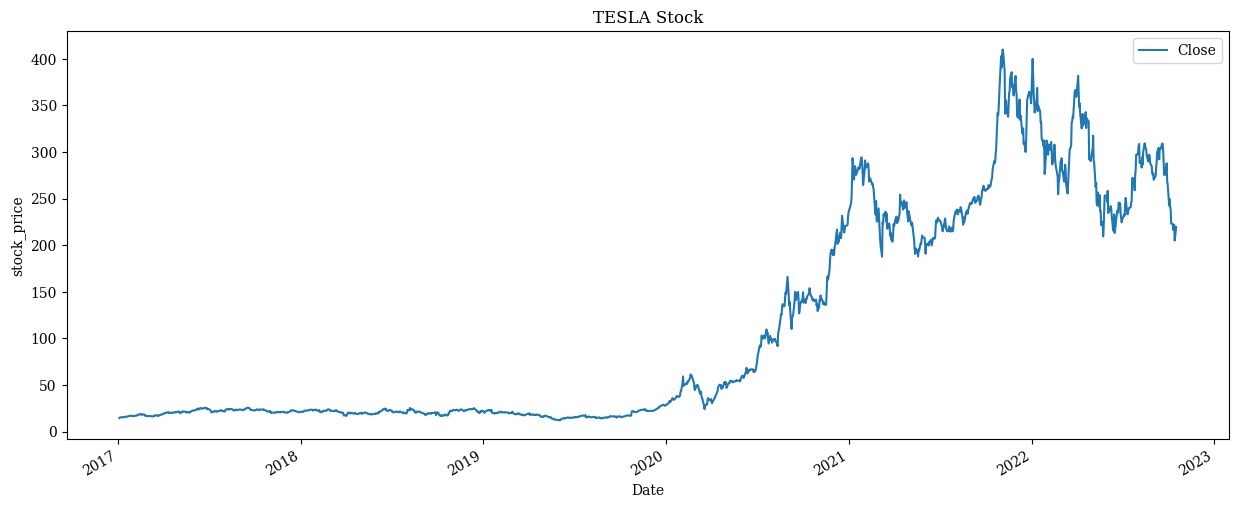

In [132]:
df = pd.read_feather('./stock_data/input/TSLA.ftr')
df[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("TESLA Stock")
plt.show()
# Plot 1

In [133]:
df_tsla = pd.read_feather('./stock_data/input/TSLA.ftr')
df_tsla = df_tsla.fillna(method='ffill')
print(list(df_tsla.columns))
# Setting rescaler
scaler = MinMaxScaler(feature_range=(-1, 1))
df_tsla['Close'] = scaler.fit_transform(df_tsla['Close'].values.reshape(-1, 1))
df_tsla.drop(['Open', 'High','Low','Adj Close','Volume','Name'], inplace=True, axis=1)

def load_data(stock, look_back):
    data_raw = stock.values  # convert to numpy array
    data = []
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]
    return [x_train, y_train, x_test, y_test]

# print(df_tsla.columns)
look_back = 180  # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_tsla, look_back)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)
print(x_train)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name']
x_train.shape =  (1022, 179, 1)
y_train.shape =  (1022, 1)
x_test.shape =  (256, 179, 1)
y_test.shape =  (256, 1)
[[[-0.98726422]
  [-0.98391446]
  [-0.98399485]
  ...
  [-0.93345035]
  [-0.93272345]
  [-0.93098492]]

 [[-0.98391446]
  [-0.98399485]
  [-0.98323781]
  ...
  [-0.93272345]
  [-0.93098492]
  [-0.93430119]]

 [[-0.98399485]
  [-0.98323781]
  [-0.98247741]
  ...
  [-0.93098492]
  [-0.93430119]
  [-0.93469981]]

 ...

 [[ 0.3553055 ]
  [ 0.35806898]
  [ 0.41528296]
  ...
  [ 0.23844925]
  [ 0.24901773]
  [ 0.24744324]]

 [[ 0.35806898]
  [ 0.41528296]
  [ 0.41911845]
  ...
  [ 0.24901773]
  [ 0.24744324]
  [ 0.25106098]]

 [[ 0.41528296]
  [ 0.41911845]
  [ 0.387413  ]
  ...
  [ 0.24744324]
  [ 0.25106098]
  [ 0.2692503 ]]]


In [134]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [135]:
y_train.size(),x_train.size()

(torch.Size([1022, 1]), torch.Size([1022, 179, 1]))

In [136]:
# Build model
#####################
input_dim = 1
hidden_dim = 32 #Here is where the Magic happens
num_layers = 2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [137]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.1167791411280632
Epoch  20 MSE:  0.028395546600222588
Epoch  30 MSE:  0.009795513935387135
Epoch  40 MSE:  0.0030436713714152575
Epoch  50 MSE:  0.0024145126808434725
Epoch  60 MSE:  0.0022384256590157747
Epoch  70 MSE:  0.0019153435714542866
Epoch  80 MSE:  0.0016961190849542618
Epoch  90 MSE:  0.001551312510855496


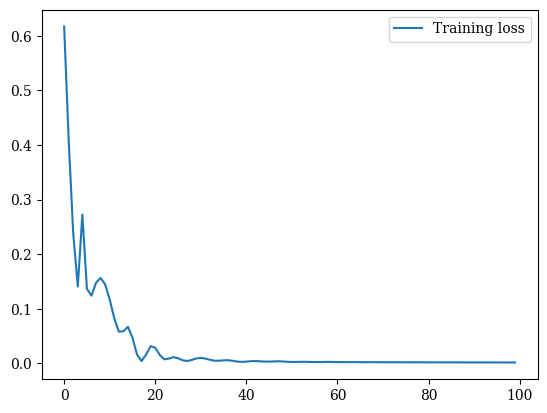

torch.Size([1022, 1])

In [138]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()
np.shape(y_train_pred)

In [139]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 7.57 RMSE
Test Score: 42.38 RMSE


1458
256


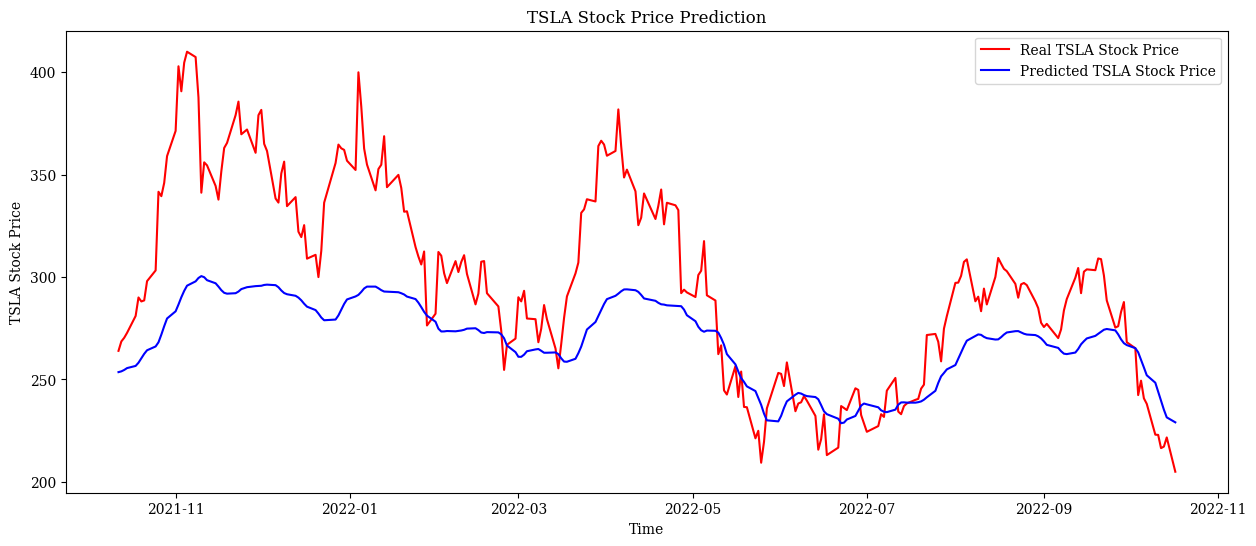

In [140]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
# print(df_tsla[1178])
print(len(df_tsla))
print(len(y_test_pred))
axes.plot(df_tsla[len(df_tsla)-len(y_test):].index, y_test, color = 'red', label = 'Real TSLA Stock Price')
axes.plot(df_tsla[len(df_tsla)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted TSLA Stock Price')
# axes.xticks(np.arange(0,394,50))
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.savefig('tsla_pred.png')
plt.show()